# **Credit Card Fraud Detection**

**About Dataset (from Kaggle):**

**Context:**
*  It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
  
**Content:**
* The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
* It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
* Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

**Update (03/05/2021):**
A simulator for transaction data has been released as part of the practical handbook on Machine Learning for Credit Card Fraud Detection - https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html. We invite all practitioners interested in fraud detection datasets to also check out this data simulator, and the methodologies for credit card fraud detection presented in the book.

**Acknowledgements:**
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

**Summary:**

In this notebook, we explore various machine‑learning techniques to determine how accurately they can classify credit card transactions as legitimate or fraudulent. The dataset is highly imbalanced, with fraud cases representing a very small fraction of all transactions. Although most of the original feature names are anonymized and transformed for privacy reasons, the dataset still provides enough structure to investigate patterns and build effective predictive models.

**Our goal is to:**
* Understand the characteristics of the dataset.
* Handle extreme class imbalance using techniques such as SMOTE and NearMiss.
* Train and evaluate multiple models, including Logistic Regression, Random Forest, XGBoost, and a Neural Network.
* Compare their performance using metrics suited for imbalanced classification.
* Identify the most reliable model for detecting fraud while minimizing false positives.

Despite the anonymization of features, we can still perform meaningful analysis, evaluate model behavior, and assess each method’s ability to distinguish fraudulent transactions from normal ones. This notebook walks through the end‑to‑end workflow — from preprocessing to model training, evaluation, and selection — aiming to build a practical and effective fraud‑detection model.

**Key takeaways:**
1. Never evaluate on resampled data.

   SMOTE and NearMiss must only be applied to the training fold inside cross-validation, never to the validation or test sets. Testing on resampled data causes massive data leakage and gives misleadingly high performance.

2. Accuracy is not useful for imbalanced datasets.

   With fraud rates near 0.1%, accuracy stays around 99% no matter what. Better metrics are Precision (How many predicted frauds are correct?), Recall (How many real frauds did we catch?), F1-score, AUC, Average Precision (PR AUC).

3. SMOTE helps—but adds noise.

   It boosts recall and stabilizes learning in neural networks. But it can oversmooth rare fraud patterns, causing subtle fraud cases to be missed.

4. Undersampling (NearMiss) improves recall but hurts precision.

   Good at finding fraud cases. But it removes many legitimate examples → high false positives. In a real bank, too many false fraud alerts = customer dissatisfaction + operational burden.

5. Neural Network + SMOTE performed best overall.

   Very high precision (≈94%) avoids customer complaints and false alarms. Strong recall (≈79%) catches most fraudulent transactions. Highest AP (≈0.87) among all tested models shows excellent ranking quality.

6. Threshold tuning is critical.

   Default threshold (0.5) isn’t optimal in fraud detection. Adjusting the threshold lets you choose: higher precision, higher recall, or a balanced F1.

7. Real-world fraud detection needs balance

   Too many false positives → angry customers. Too many false negatives → financial losses. The chosen model should minimize operational risk while still catching fraud.

In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping with '...'
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


**Data read and exploration**
* There are no null values so no need to handle the missing values.
* Dataset is highly imbalanced, 99.83% non-fraud vs 0.17% fraud data.
* The target varible is Class (1 for fraud and 0 for non-fraud). Known key features are trasaction time and amount only and all other columns are already PCA transformations due to privacy reasons.
* The distributions of time and amount are skewed so they will need to be scaled before modelling.
* V2, V4, V11 and V19 are highly postive relatd to Class, and V10, V12, V14,and V17 are highly negative relatd to Class.

In [53]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [54]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,2.240150e-15,1.724421e-15,-1.245415e-15,8.238900e-16,1.213481e-15,4.866699e-15,1.432227e-15,-3.768179e-16,9.707851e-16,1.036249e-15,6.386744e-16,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [44]:
# Check null values
df.isnull().sum().to_frame(name='Null Value Count').T

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Null Value Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [46]:
fraud_counts = df.groupby('Class').size().reset_index(name='Fraud')
fraud_counts['Percentage'] = (fraud_counts['Fraud'] / fraud_counts['Fraud'].sum()) * 100
fraud_counts

,Class,Fraud,Percentage
0,0,284315,99.827251
1,1,492,0.172749


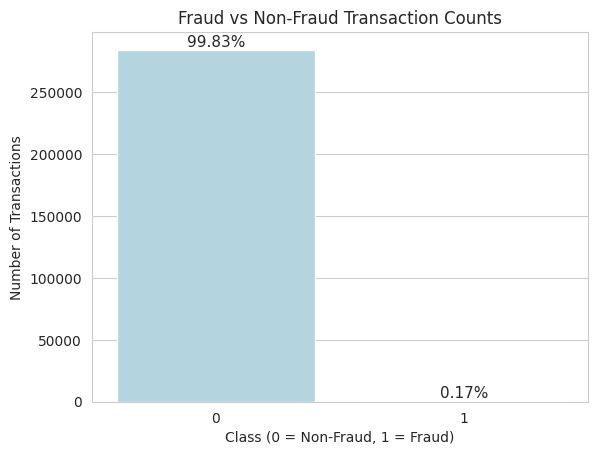

In [47]:
sns.barplot(x='Class', y='Fraud', data=fraud_counts,palette = ["#ADD8E6", "#DF0101"])
plt.title('Fraud vs Non-Fraud Transaction Counts')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Number of Transactions')

for i, row in fraud_counts.iterrows():
    plt.text(i, row['Fraud'], f"{row['Percentage']:.2f}%", ha='center', va='bottom', fontsize=11)

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

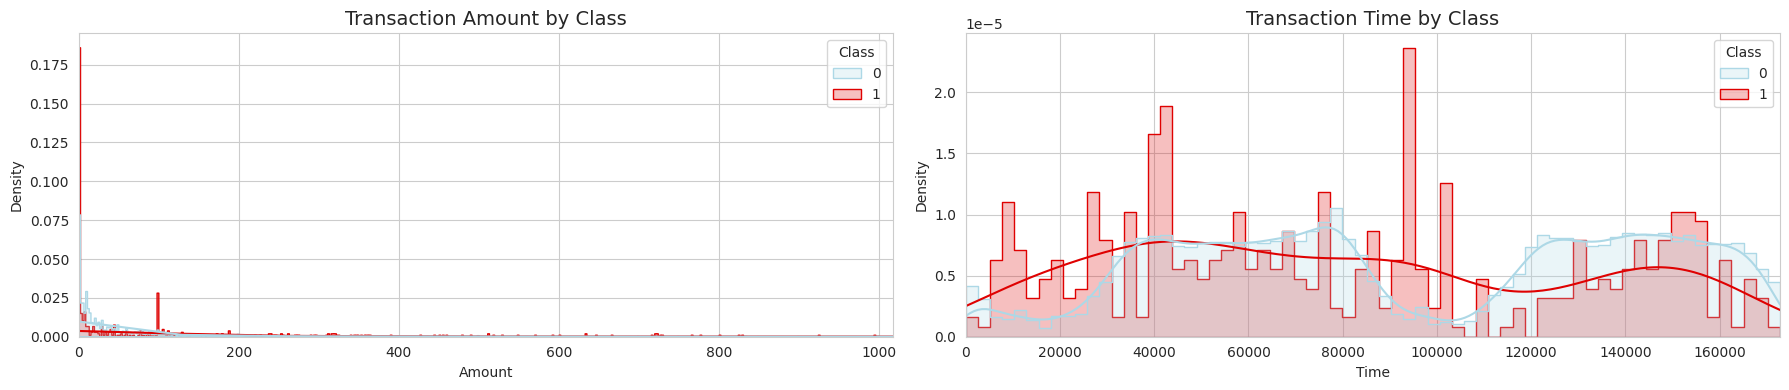

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(data=df, x='Amount', hue='Class', ax=ax[0], kde=True, element='step', stat='density', common_norm=False, palette=["#ADD8E6", "#DF0101"])
ax[0].set_title('Transaction Amount by Class', fontsize=14)
ax[0].set_xlim([0, df['Amount'].quantile(0.99)])  # Optional: zoom in to 99th percentile

sns.histplot(data=df, x='Time', hue='Class', ax=ax[1], kde=True, element='step', stat='density', common_norm=False, palette=["#ADD8E6", "#DF0101"])
ax[1].set_title('Transaction Time by Class', fontsize=14)
ax[1].set_xlim([0, df['Time'].max()])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

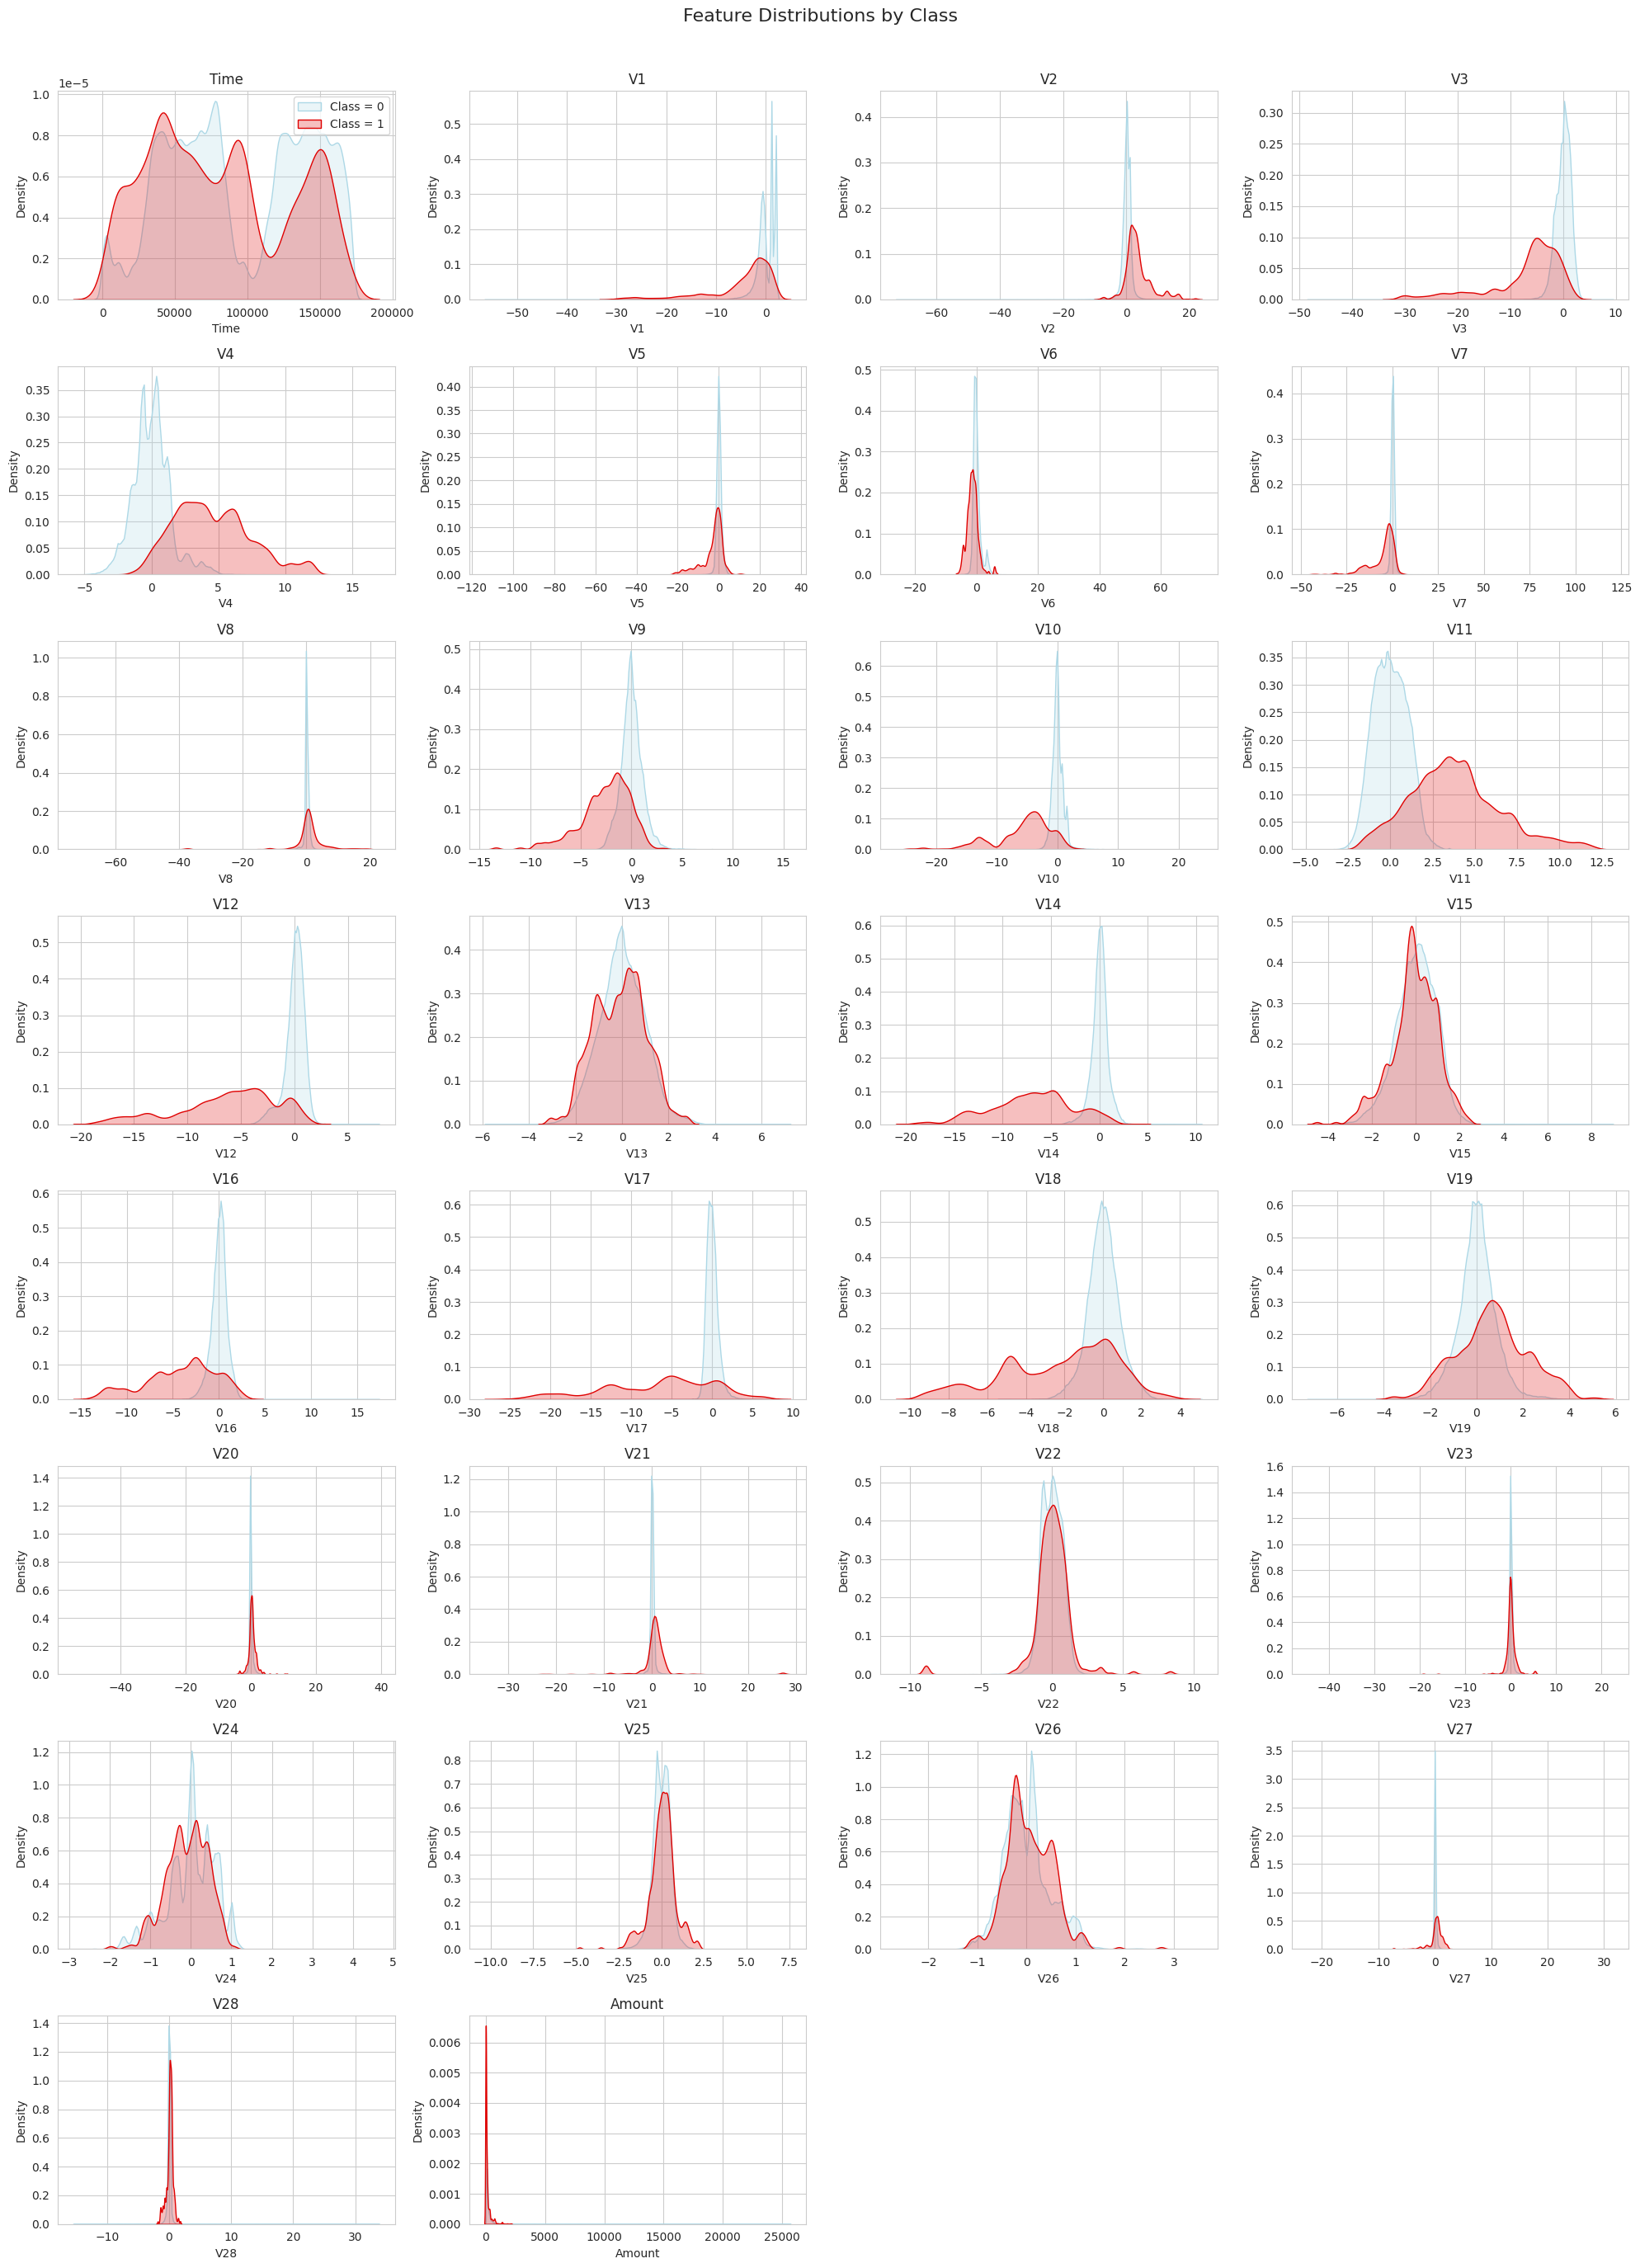

In [49]:
# Split data
t0 = df[df['Class'] == 0]
t1 = df[df['Class'] == 1]

# Filter numeric columns only
numeric_cols = df.select_dtypes(include=np.number).columns.drop('Class')

# Set up plot grid
sns.set_style('whitegrid')
fig, ax = plt.subplots(8, 4, figsize=(20, 28))
ax = ax.flatten()

# Plot KDEs
for i, feature in enumerate(numeric_cols):
    sns.kdeplot(t0[feature], bw_adjust=0.5, label="Class = 0", ax=ax[i], fill=True, color="#ADD8E6")
    sns.kdeplot(t1[feature], bw_adjust=0.5, label="Class = 1", ax=ax[i], fill=True, color="#DF0101")
    ax[i].set_title(feature, fontsize=12)
    ax[i].tick_params(axis='both', which='major', labelsize=10)

    # Add legend only to first plot
    if i == 0:
        ax[i].legend()

# Hide unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.suptitle('Feature Distributions by Class', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

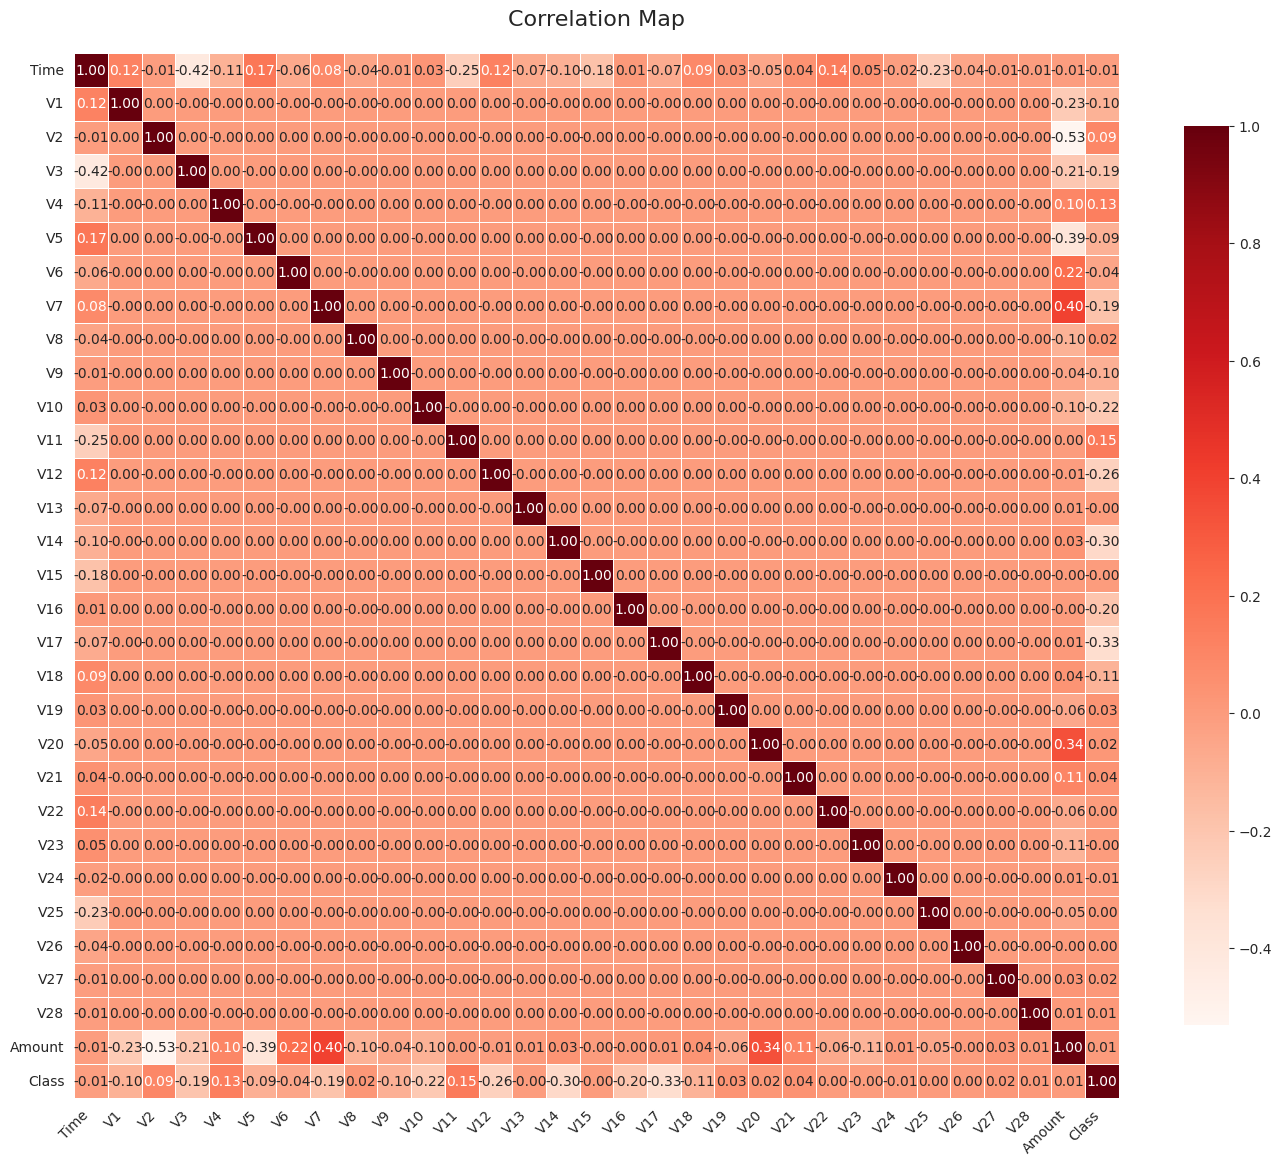

In [50]:
plt.figure(figsize=(14, 12))
plt.title('Correlation Map', fontsize=16, pad=20)

# Compute correlation matrix
corr = df.corr()

# Create heatmap
sns.heatmap(
    corr,
    annot=True,               # Show correlation values
    fmt=".2f",                # Format to 2 decimal places
    cmap="Reds",              # Color palette
    linewidths=0.5,           # Grid lines between cells
    linecolor='white',
    square=True,              # Square cells
    cbar_kws={"shrink": 0.8}, # Shrink color bar
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Data Preprocessing**
* Scaled two key features Amount and Time.
* Removed the outliers on the variables with high correlations to Class based on IQR.

In [55]:
scaler = RobustScaler()

required_cols = ['Amount', 'Time']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns required for scaling: {missing}")

scaled = scaler.fit_transform(df[required_cols])
df[['Scaled_amount', 'Scaled_time']] = scaled
df = df.drop(columns=required_cols)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_amount,Scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


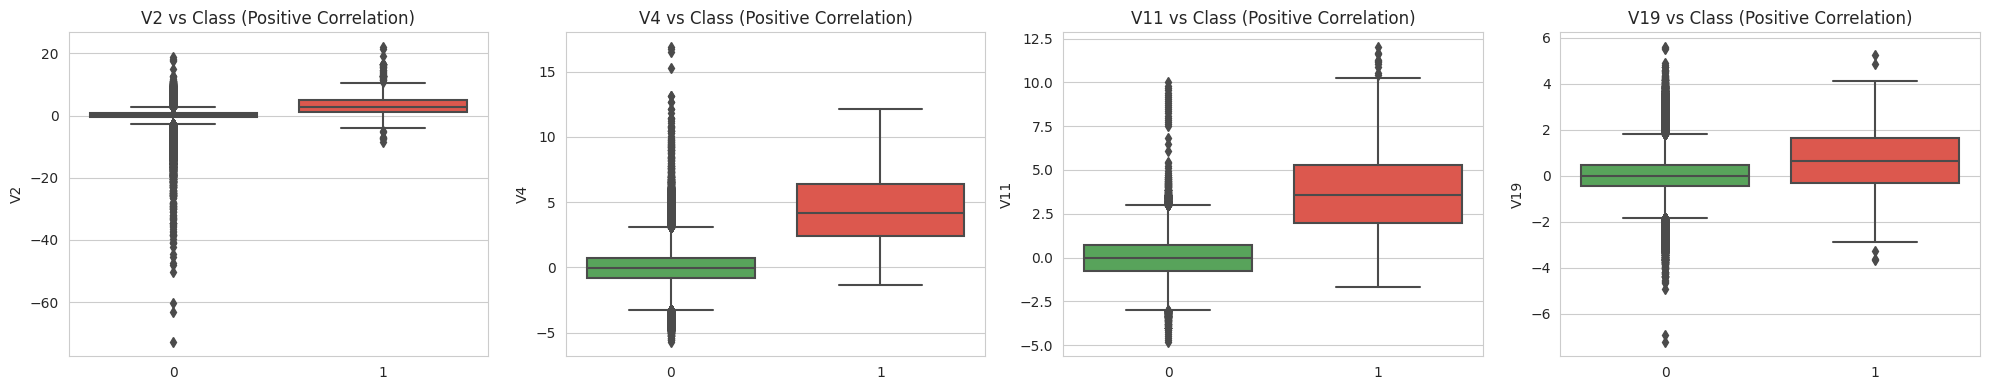

In [56]:
# Features with positive correlation
features = ['V2', 'V4', 'V11', 'V19']
titles = [f"{feat} vs Class (Positive Correlation)" for feat in features]

colors = ["#4CAF50", "#F44336"]  # Green for non-fraud, Red for fraud

fig, axes = plt.subplots(ncols=len(features), figsize=(20, 4))

for ax, feat, title in zip(axes, features, titles):
    sns.boxplot(x="Class", y=feat, data=df, palette=colors, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("")  
    ax.set_ylabel(feat)

plt.tight_layout()
plt.show()

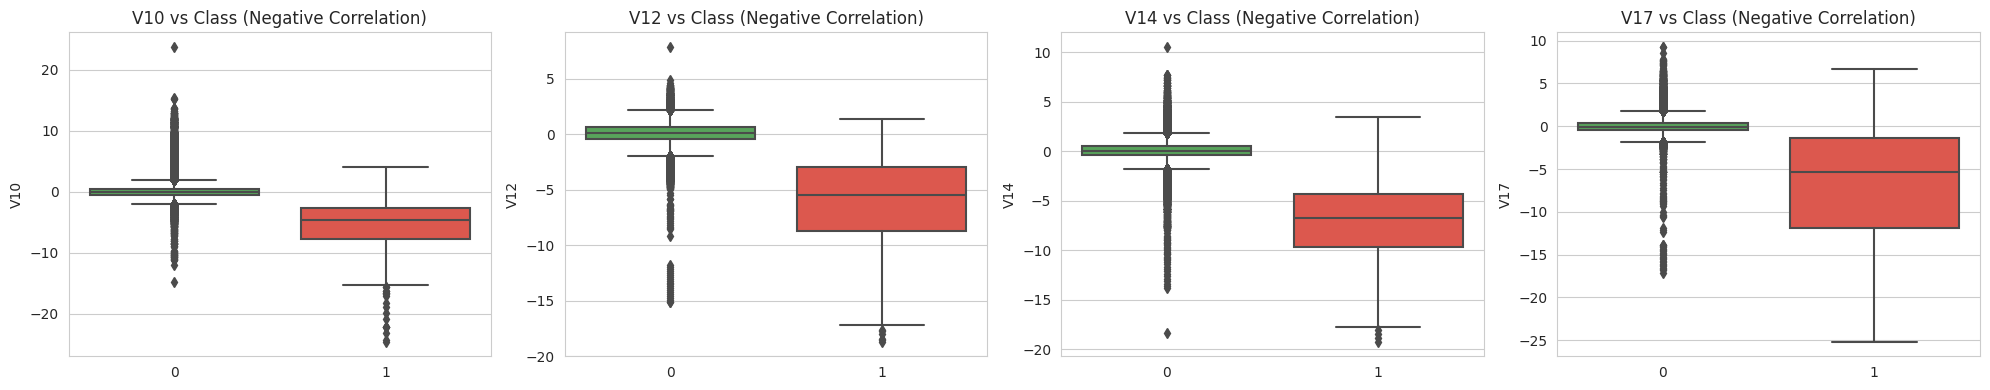

In [57]:
# Features with negative correlation
features = ['V10', 'V12', 'V14', 'V17']
titles = [f"{feat} vs Class (Negative Correlation)" for feat in features]

colors = ["#4CAF50", "#F44336"]  # Green for non-fraud, Red for fraud

fig, axes = plt.subplots(ncols=len(features), figsize=(20, 4))

for ax, feat, title in zip(axes, features, titles):
    sns.boxplot(x="Class", y=feat, data=df, palette=colors, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("")  
    ax.set_ylabel(feat)

plt.tight_layout()
plt.show()

In [58]:
# Remove outliers for the variables with high correlations
def remove_iqr_outliers_in_fraud(df: pd.DataFrame, feature: str, class_col: str = "Class", iqr_multiplier: float = 1.5, verbose: bool = True):
    """
    Removes outliers from `feature` using IQR thresholds computed on the subset where `class_col == 1`.
    Returns the modified DataFrame and a dictionary with thresholds & counts.
    """
    # Work on a copy to avoid chained assignment issues
    df = df.copy()

    # Sanity checks
    if feature not in df.columns:
        raise KeyError(f"Feature '{feature}' not found in DataFrame.")
    if class_col not in df.columns:
        raise KeyError(f"Class column '{class_col}' not found in DataFrame.")

    fraud_mask = df[class_col] == 1
    fraud_values = df.loc[fraud_mask, feature].values

    if fraud_values.size == 0:
        if verbose:
            print(f"[{feature}] No fraud rows found. Skipping outlier removal.")
        return df, {
            "feature": feature, "q25": np.nan, "q75": np.nan, "iqr": np.nan,
            "lower": np.nan, "upper": np.nan,
            "num_outliers_in_fraud": 0,
            "rows_removed": 0,
            "remaining_rows": len(df)
        }

    # Quartiles and IQR
    q25, q75 = np.percentile(fraud_values, [25, 75])
    iqr = q75 - q25
    cut_off = iqr_multiplier * iqr
    lower, upper = q25 - cut_off, q75 + cut_off

    # Count outliers within fraud
    outliers_in_fraud = [x for x in fraud_values if (x < lower) or (x > upper)]
    num_outliers = len(outliers_in_fraud)

    # Drop rows across the whole df where feature is outside bounds
    to_drop_idx = df[(df[feature] < lower) | (df[feature] > upper)].index
    rows_removed = len(to_drop_idx)
    df = df.drop(index=to_drop_idx)

    if verbose:
        print(f"Feature: {feature}")
        print(f"  Quartile 25: {q25:.6f} | Quartile 75: {q75:.6f}")
        print(f"  IQR: {iqr:.6f} | Cut-off ({iqr_multiplier}×IQR): {cut_off:.6f}")
        print(f"  Lower: {lower:.6f} | Upper: {upper:.6f}")
        print(f"  Outliers within fraud subset: {num_outliers}")
        print(f"  Rows removed (all classes): {rows_removed}")
        print(f"  Remaining rows: {len(df)}")
        print("----" * 22)

    return df, {
        "feature": feature, "q25": q25, "q75": q75, "iqr": iqr,
        "lower": lower, "upper": upper,
        "num_outliers_in_fraud": num_outliers,
        "rows_removed": rows_removed,
        "remaining_rows": len(df)
    }

# Apply to requested features
features_to_clean = ["V14", "V12", "V10"]
stats_log = []

for feat in features_to_clean:
    df, stats = remove_iqr_outliers_in_fraud(df, feature=feat, class_col="Class", iqr_multiplier=1.5, verbose=True)
    stats_log.append(stats)

# Summarize stats
summary = pd.DataFrame(stats_log)
print(summary)


Feature: V14
  Quartile 25: -9.692723 | Quartile 75: -4.282821
  IQR: 5.409902 | Cut-off (1.5×IQR): 8.114853
  Lower: -17.807576 | Upper: 3.832032
  Outliers within fraud subset: 4
  Rows removed (all classes): 297
  Remaining rows: 284510
----------------------------------------------------------------------------------------
Feature: V12
  Quartile 25: -8.673033 | Quartile 75: -2.893031
  IQR: 5.780003 | Cut-off (1.5×IQR): 8.670004
  Lower: -17.343037 | Upper: 5.776973
  Outliers within fraud subset: 4
  Rows removed (all classes): 4
  Remaining rows: 284506
----------------------------------------------------------------------------------------
Feature: V10
  Quartile 25: -7.466659 | Quartile 75: -2.511861
  IQR: 4.954797 | Cut-off (1.5×IQR): 7.432196
  Lower: -14.898855 | Upper: 4.920335
  Outliers within fraud subset: 27
  Rows removed (all classes): 1497
  Remaining rows: 283009
----------------------------------------------------------------------------------------
  feature    

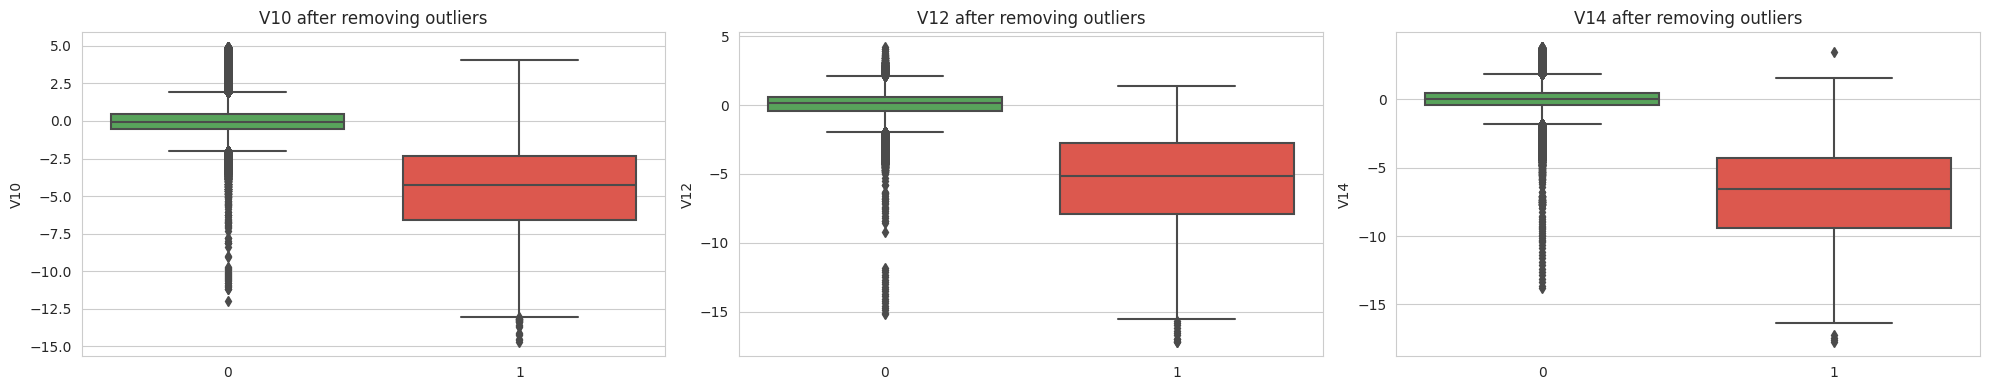

In [59]:
# Replot boxplots
features = ['V10', 'V12', 'V14']
titles = [f"{feat} after removing outliers" for feat in features]

colors = ["#4CAF50", "#F44336"]  # Green for non-fraud, Red for fraud

fig, axes = plt.subplots(ncols=len(features), figsize=(20, 4))

for ax, feat, title in zip(axes, features, titles):
    sns.boxplot(x="Class", y=feat, data=df, palette=colors, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("")  
    ax.set_ylabel(feat)

plt.tight_layout()
plt.show()

In [60]:
df.shape

(283009, 31)

In [ ]:
# !pip install -U "scikit-learn==1.5.2" "imbalanced-learn==0.13.0"

# import sklearn, imblearn, numpy as np
# print("sklearn:", sklearn.__version__)
# print("imblearn:", imblearn.__version__)
# print("numpy:", np.__version__)

# from imblearn.under_sampling import NearMiss
# from imblearn.pipeline import Pipeline

**Modelling and Evaluation**
* Since the fraud data is highly imbalanced, we tried modelling with both undersampling and oversampling.
* We used Nearmiss for undersampling and trained model with cross validation under logtistic regression, random forrest and XGBoost, among which logistic regression shows the best result (Accuracy: 0.7683 / Precision: 0.0066 / Recall: 0.9560 / F1: 0.0131 / AUC: 0.9477) with high recall however the prescision is still quite low.
* We then tried oversampling use SMOTE which shows a better result (Accuracy: 0.9721 / Precision: 0.0479 / Recall: 0.8681 / F1: 0.0908 / ROC AUC:   0.9607 / AP (PR AUC): 0.6686) however still the relatively low precison under 0.5 threhold.
* We finally trained NN + SMOTE which shows much improved results with very high precision with good recall and best-in-class AP (Accuracy: 0.9996 / Precision: 0.9351 / Recall: 0.7912 / F1: 0.8571 / AUC: 0.9648 / AP: 0.8657).

In [61]:
X = df.drop(columns='Class')
y = df['Class']

# ---- Outer holdout split (e.g., 80/20) ----
outer_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(outer_sss.split(X, y))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Label distribution for sanity
print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

# ---- Model & Pipeline for logistic regression----
log_reg = LogisticRegression(
    solver='liblinear',        # robust for small/imbalanced sets
    class_weight='balanced',   # optional; can help recall on minority class
    random_state=42
)


pipeline = Pipeline([
    ('undersample', NearMiss(sampling_strategy='majority')),
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False if sparse; drop if not sparse
    ('clf', log_reg),
])

# ---- Inner CV on the training split ----
inner_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auc = [], [], [], [], []

for tr_idx, val_idx in inner_sss.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    # Fit on current training fold; NearMiss runs inside the pipeline on X_tr/y_tr only
    pipeline.fit(X_tr, y_tr)

    # Predict labels and probabilities on validation fold
    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val)[:, 1]

    # Metrics (pos_label=1 for fraud)
    cv_accuracy.append(accuracy_score(y_val, y_val_pred))
    cv_precision.append(precision_score(y_val, y_val_pred, pos_label=1, zero_division=0))
    cv_recall.append(recall_score(y_val, y_val_pred, pos_label=1, zero_division=0))
    cv_f1.append(f1_score(y_val, y_val_pred, pos_label=1, zero_division=0))
    cv_auc.append(roc_auc_score(y_val, y_val_proba))

print("\n=== Cross-Validation (train split - logreg) ===")
print(f"Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(f"Precision: {np.mean(cv_precision):.4f} ± {np.std(cv_precision):.4f}")
print(f"Recall:    {np.mean(cv_recall):.4f} ± {np.std(cv_recall):.4f}")
print(f"F1:        {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"AUC:       {np.mean(cv_auc):.4f} ± {np.std(cv_auc):.4f}")

# ---- Final fit on full training set & evaluate on holdout ----
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n=== Holdout (test split - logreg) ===")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, pos_label=1, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, pos_label=1, zero_division=0):.4f}")
print(f"F1:        {f1_score(y_test, y_test_pred, pos_label=1, zero_division=0):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_test_proba):.4f}")

# ---- Inspect NearMiss effect on the training data distribution ----
nm = NearMiss(sampling_strategy='majority')
X_nm, y_nm = nm.fit_resample(X_train, y_train)
print("\nNearMiss label distribution on training:", Counter(y_nm))


Train label distribution: Counter({0: 226041, 1: 366})
Test label distribution: Counter({0: 56511, 1: 91})

=== Cross-Validation (train split - logreg) ===
Accuracy: 0.6904 ± 0.0585
Precision: 0.0049 ± 0.0012
Recall:    0.9096 ± 0.0239
F1:        0.0098 ± 0.0024
AUC:       0.9227 ± 0.0155

=== Holdout (test split - logreg) ===
Accuracy: 0.7683
Precision: 0.0066
Recall:    0.9560
F1:        0.0131
AUC:       0.9477

NearMiss label distribution on training: Counter({0: 366, 1: 366})


In [62]:
# ---- Model & Pipeline for Random Forest ----
rf_clf = RandomForestClassifier(
    n_estimators=400,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline([
    ('undersample', NearMiss(sampling_strategy='majority')),
    ('scaler', 'passthrough'),  # Trees don't need scaling
    ('clf', rf_clf),
])

# ---- Inner CV for Random Forest ----
cv_accuracy_rf, cv_precision_rf, cv_recall_rf, cv_f1_rf, cv_auc_rf = [], [], [], [], []

for tr_idx, val_idx in inner_sss.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    rf_pipeline.fit(X_tr, y_tr)
    y_val_pred_rf = rf_pipeline.predict(X_val)
    y_val_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]

    cv_accuracy_rf.append(accuracy_score(y_val, y_val_pred_rf))
    cv_precision_rf.append(precision_score(y_val, y_val_pred_rf, pos_label=1, zero_division=0))
    cv_recall_rf.append(recall_score(y_val, y_val_pred_rf, pos_label=1, zero_division=0))
    cv_f1_rf.append(f1_score(y_val, y_val_pred_rf, pos_label=1, zero_division=0))
    cv_auc_rf.append(roc_auc_score(y_val, y_val_proba_rf))

print("\n=== Cross-Validation (Random Forest) ===")
print(f"Accuracy: {np.mean(cv_accuracy_rf):.4f} ± {np.std(cv_accuracy_rf):.4f}")
print(f"Precision: {np.mean(cv_precision_rf):.4f} ± {np.std(cv_precision_rf):.4f}")
print(f"Recall:    {np.mean(cv_recall_rf):.4f} ± {np.std(cv_recall_rf):.4f}")
print(f"F1:        {np.mean(cv_f1_rf):.4f} ± {np.std(cv_f1_rf):.4f}")
print(f"AUC:       {np.mean(cv_auc_rf):.4f} ± {np.std(cv_auc_rf):.4f}")

# ---- Final fit & holdout evaluation ----
rf_pipeline.fit(X_train, y_train)
y_test_pred_rf = rf_pipeline.predict(X_test)
y_test_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Holdout (Random Forest) ===")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_rf, pos_label=1, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_rf, pos_label=1, zero_division=0):.4f}")
print(f"F1:        {f1_score(y_test, y_test_pred_rf, pos_label=1, zero_division=0):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_test_proba_rf):.4f}")




=== Cross-Validation (Random Forest) ===
Accuracy: 0.1657 ± 0.1267
Precision: 0.0019 ± 0.0003
Recall:    0.9699 ± 0.0251
F1:        0.0038 ± 0.0006
AUC:       0.9131 ± 0.0168

=== Holdout (Random Forest) ===
Accuracy: 0.1694
Precision: 0.0019
Recall:    0.9780
F1:        0.0038
AUC:       0.9462


In [63]:
# Compute scale_pos_weight for imbalance
neg, pos = Counter(y_train)[0], Counter(y_train)[1]
scale_pos_weight = neg / pos

# ---- Model & Pipeline for XGBoost ----
xgb_clf = XGBClassifier(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_pipeline = Pipeline([
    ('undersample', NearMiss(sampling_strategy='majority')),
    ('scaler', 'passthrough'),  # Trees don't need scaling
    ('clf', xgb_clf),
])

# ---- Inner CV for XGBoost ----
cv_accuracy_xgb, cv_precision_xgb, cv_recall_xgb, cv_f1_xgb, cv_auc_xgb = [], [], [], [], []

for tr_idx, val_idx in inner_sss.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    xgb_pipeline.fit(X_tr, y_tr)
    y_val_pred_xgb = xgb_pipeline.predict(X_val)
    y_val_proba_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]

    cv_accuracy_xgb.append(accuracy_score(y_val, y_val_pred_xgb))
    cv_precision_xgb.append(precision_score(y_val, y_val_pred_xgb, pos_label=1, zero_division=0))
    cv_recall_xgb.append(recall_score(y_val, y_val_pred_xgb, pos_label=1, zero_division=0))
    cv_f1_xgb.append(f1_score(y_val, y_val_pred_xgb, pos_label=1, zero_division=0))
    cv_auc_xgb.append(roc_auc_score(y_val, y_val_proba_xgb))

print("\n=== Cross-Validation (XGBoost) ===")
print(f"Accuracy: {np.mean(cv_accuracy_xgb):.4f} ± {np.std(cv_accuracy_xgb):.4f}")
print(f"Precision: {np.mean(cv_precision_xgb):.4f} ± {np.std(cv_precision_xgb):.4f}")
print(f"Recall:    {np.mean(cv_recall_xgb):.4f} ± {np.std(cv_recall_xgb):.4f}")
print(f"F1:        {np.mean(cv_f1_xgb):.4f} ± {np.std(cv_f1_xgb):.4f}")
print(f"AUC:       {np.mean(cv_auc_xgb):.4f} ± {np.std(cv_auc_xgb):.4f}")

# ---- Final fit & holdout evaluation ----
xgb_pipeline.fit(X_train, y_train)
y_test_pred_xgb = xgb_pipeline.predict(X_test)
y_test_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Holdout (XGBoost) ===")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_xgb, pos_label=1, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_xgb, pos_label=1, zero_division=0):.4f}")
print(f"F1:        {f1_score(y_test, y_test_pred_xgb, pos_label=1, zero_division=0):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_test_proba_xgb):.4f}")




=== Cross-Validation (XGBoost) ===
Accuracy: 0.1454 ± 0.0948
Precision: 0.0019 ± 0.0002
Recall:    0.9863 ± 0.0150
F1:        0.0037 ± 0.0004
AUC:       0.9222 ± 0.0186

=== Holdout (XGBoost) ===
Accuracy: 0.1256
Precision: 0.0018
Recall:    0.9780
F1:        0.0036
AUC:       0.9510


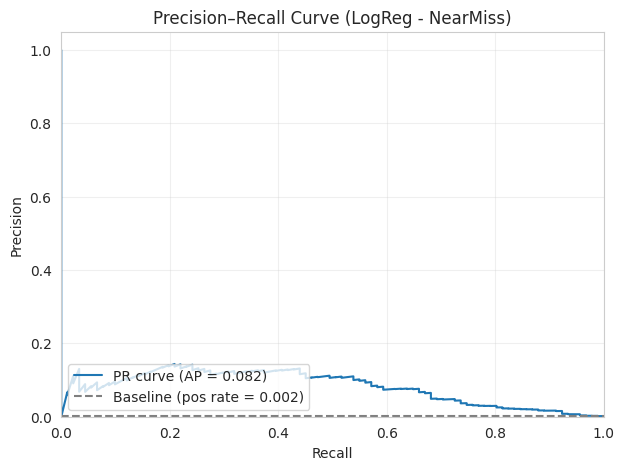

In [64]:
# Compute PR curve & AP
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba, pos_label=1)
ap = average_precision_score(y_test, y_test_proba)

# Baseline: positive class prevalence in the test set
pos_rate = (y_test == 1).mean()

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.3f})', color='tab:blue')
plt.hlines(pos_rate, xmin=0, xmax=1, colors='tab:gray', linestyles='--',
           label=f'Baseline (pos rate = {pos_rate:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (LogReg - NearMiss)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

Train label distribution: Counter({0: 226041, 1: 366})
Test  label distribution: Counter({0: 56511, 1: 91})
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params: {'smote__k_neighbors': 7, 'clf__penalty': 'l1', 'clf__C': 10}
Best CV Average Precision (AP): 0.7214

=== Holdout (test) — SMOTE + Logistic Regression ===
Accuracy:  0.9721
Precision: 0.0479
Recall:    0.8681
F1:        0.0908
ROC AUC:   0.9607
AP (PR AUC): 0.6686


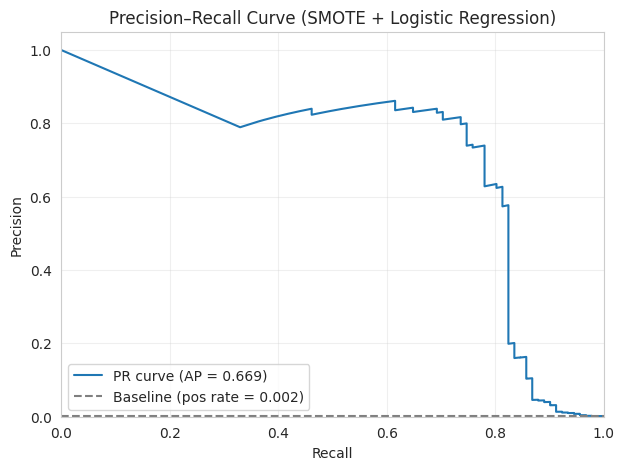

In [65]:
from imblearn.pipeline import Pipeline as ImbPipeline  # use imblearn Pipeline
# ---- Sanity check: label distribution ----
print("Train label distribution:", Counter(y_train))
print("Test  label distribution:", Counter(y_test))

# ---- Pipeline: scale -> SMOTE -> Logistic Regression ----
# If your X is sparse, keep with_mean=False; otherwise you can remove it (default True).
scaler = StandardScaler(with_mean=False)  # set to True if X is dense
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)

log_reg = LogisticRegression(
    solver='liblinear',       # supports l1/l2
    class_weight=None,        # SMOTE balances classes; avoid double-weighting
    max_iter=1000,
    random_state=42
)

smote_lr_pipe = ImbPipeline(steps=[
    ('scale', scaler),
    ('smote', smote),
    ('clf', log_reg),
])

# ---- Hyperparameter search on the pipeline ----
param_distributions = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'smote__k_neighbors': [3, 5, 7],
    # Optionally compare weighting anyway:
    # 'clf__class_weight': [None, 'balanced'],
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=smote_lr_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='average_precision',   # PR AUC — good for imbalance
    cv=inner_cv,
    n_jobs=-1,
    verbose=1,
    refit=True,                    # refit best on full training set
    random_state=42
)

# ---- Fit on the training set (CV happens inside) ----
rs.fit(X_train, y_train)
best_pipe = rs.best_estimator_

print("\nBest params:", rs.best_params_)
print(f"Best CV Average Precision (AP): {rs.best_score_:.4f}")

# ---- Evaluate on the holdout test set ----
y_test_pred = best_pipe.predict(X_test)
y_test_proba = best_pipe.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)
rec  = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)
f1   = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)
roc  = roc_auc_score(y_test, y_test_proba)        # use probabilities!
ap   = average_precision_score(y_test, y_test_proba)

print("\n=== Holdout (test) — SMOTE + Logistic Regression ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"AP (PR AUC): {ap:.4f}")

# ---- PR curve with baseline ----
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba, pos_label=1)
pos_rate = (y_test == 1).mean()

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.3f})', color='tab:blue')
plt.hlines(pos_rate, xmin=0, xmax=1, colors='tab:gray', linestyles='--',
           label=f'Baseline (pos rate = {pos_rate:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (SMOTE + Logistic Regression)')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# %pip install --upgrade --force-reinstall "protobuf==3.20.*" "grpcio<2.0" "googleapis-common-protos<2.0"

In [ ]:
# import tensorflow as tf
# import google.protobuf
# import scikeras

# print("TF:", tf.__version__)
# print("protobuf:", google.protobuf.__version__)
# print("SciKeras:", scikeras.__version__)


Before SMOTE: Counter({0: 226041, 1: 366})
After SMOTE: Counter({0: 226041, 1: 22604})
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


664/664 - 4s - 6ms/step - accuracy: 0.9937 - loss: 0.0369 - val_accuracy: 0.8670 - val_loss: 0.6581
Epoch 2/20
664/664 - 1s - 2ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9009 - val_loss: 0.5223
Epoch 3/20
664/664 - 1s - 2ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9022 - val_loss: 0.4931
Epoch 4/20
664/664 - 1s - 2ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9092 - val_loss: 0.4337
Epoch 5/20
664/664 - 1s - 2ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.8998 - val_loss: 0.4570
Epoch 6/20
664/664 - 1s - 2ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9149 - val_loss: 0.4099
Epoch 7/20
664/664 - 2s - 2ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9049 - val_loss: 0.3824
Epoch 8/20
664/664 - 1s - 2ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9151 - val_loss: 0.3958
Epoch 9/20
664/664 - 1s - 2ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9237 - val_loss: 0.3579
Epoch 10/20


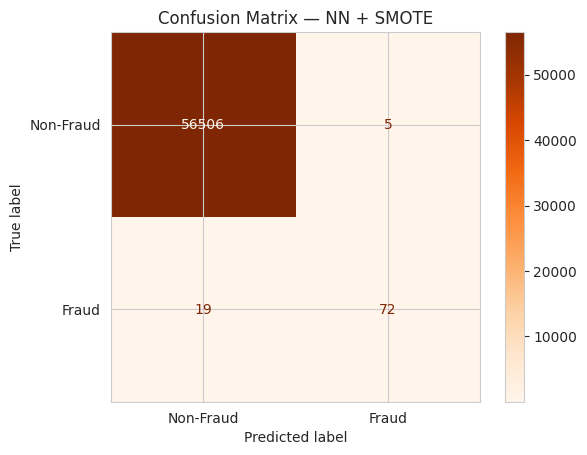

In [68]:
# ---- Scaling + SMOTE  ----

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Before SMOTE:", Counter(y_train))

sm = SMOTE(sampling_strategy=0.1, k_neighbors=5, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", Counter(y_train_sm))

# ---- NN (Sequential)  ----

n_inputs = X_train_sm.shape[1]

model = Sequential()
model.add(Dense(n_inputs, activation='relu', input_shape=(n_inputs,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---- Train NN  ----
history = model.fit(
    X_train_sm, y_train_sm,
    validation_split=0.2,
    batch_size=300,
    epochs=20,
    shuffle=True,
    verbose=2
)

# ---- Predict on test  ----
y_test_proba = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_proba >= 0.5).astype(int)   

# ---- Metrics  ----
print("\n=== Holdout (test split - NN + SMOTE) ===")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"F1:        {f1_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"AP:        {average_precision_score(y_test, y_test_proba):.4f}")

# ---- Confusion Matrix  ----
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Fraud','Fraud'])
disp.plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix — NN + SMOTE")
plt.show()